In [ ]:
# TensorFlow 설치 (기본적으로 코랩에는 TensorFlow가 설치되어 있지만, 버전 업데이트가 필요할 수 있음)
%pip install tensorflow
%pip install tensorflow keras

# 모델을 사용하기 위한 추가 라이브러리 설치
%pip install h5py

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # 모든 이미지의 픽셀 값을 0-1 범위로 스케일링
    shear_range=0.2,          # 이미지에 랜덤 전단 변환 적용
    zoom_range=0.2,           # 이미지에 랜덤 줌 변환 적용
    horizontal_flip=True      # 이미지를 랜덤으로 수평 반전
)

# 'datasets/Training' 디렉토리에서 이미지 불러오기
train_generator = train_datagen.flow_from_directory(
    '../../datasets/Training',      # 학습 데이터가 있는 디렉토리 경로
    target_size=(299, 299),   # 모델의 입력 크기에 맞게 이미지 크기 조정
    batch_size=32,            # 배치 크기
    class_mode='categorical'  # 다중 클래스 분류를 위해 categorical 모드 사용
)


Found 1615 images belonging to 2 classes.


In [21]:
# 사전 학습된 Inception-ResNet-v2 모델 로드 및 커스터마이징 (include_top=False)
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# 기존 모델의 최상위 레이어를 제거하고 새로운 분류 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling 레이어 추가
x = Dense(1024, activation='relu')(x)  # 임의의 Dense 레이어 추가
predictions = Dense(2, activation='softmax')(x)  # 정상/비정상을 위한 2개의 클래스

# 새로운 모델 생성
model = Model(inputs=base_model.input, outputs=predictions)

# 전이 학습을 위해 기존의 레이어들을 학습되지 않도록 설정
# 전 학습된 모델의 초기 레이어들은 다양한 저수준의 특징(에지, 패턴 등)을 학습하기 때문에 다양한 이미지 분류 작업에 재사용될 수 있습니다.
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# 클래스 인덱스 출력
print("Class indices:", train_generator.class_indices)

# 클래스 인덱스 반대로 맵핑하여 보기 쉽게
class_mapping = {v: k for k, v in train_generator.class_indices.items()}
print("Class mapping (index to class name):", class_mapping)

Class indices: {'anormal': 0, 'normal': 1}
Class mapping (index to class name): {0: 'anormal', 1: 'normal'}


In [26]:
# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    'model_weights_epoch_{epoch:02d}.weights.h5',  # 저장할 파일 이름 패턴
    monitor='loss',                       # 모니터링할 값 (여기서는 학습 손실)
    save_best_only=False,                 # 매 에포크마다 모델 저장
    save_weights_only=True,               # 가중치만 저장 (전체 모델 저장 시 False)
    save_freq='epoch'                     # 매 에포크마다 저장
)

In [27]:
# 모델 학습 (콜백 포함)
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,                                     # 원하는 에포크 수
    callbacks=[checkpoint]                         # 콜백 리스트에 ModelCheckpoint 추가
)

Epoch 1/10


c:\Users\SSAFY\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7522 - loss: 0.6092
Epoch 2/10
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.9062 - loss: 0.1842

c:\Users\SSAFY\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9062 - loss: 0.1842
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9417 - loss: 0.1685
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9688 - loss: 0.0986
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9470 - loss: 0.1528
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8438 - loss: 0.2472
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9546 - loss: 0.1166
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9375 - loss: 0.0934
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9647 - loss: 0.0906
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 1.0000 - loss: 0.0532


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Randomly selected image: ../../datasets/Training\normal\52_A01_B01_C060_0000000048.jpg
True label: normal
Predicted label: anormal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Accuracy: 11.80%


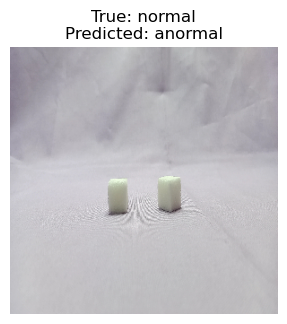

In [32]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# 무작위로 이미지를 선택하는 함수 정의
def load_random_images_from_directory(directory, num_images):
    # 'normal'과 'anormal' 디렉토리 목록
    categories = ['normal', 'anormal']
    selected_images = []

    for category in categories:
        category_path = os.path.join(directory, category)
        all_images = os.listdir(category_path)
        selected_images += [(category, os.path.join(category_path, img)) for img in all_images]

    # 전체 이미지 중 무작위로 선택
    random.shuffle(selected_images)
    selected_images = selected_images[:num_images]
    
    return selected_images

# 데이터셋 경로 설정
dataset_directory = '../../datasets/Training'

# normal과 anormal 디렉토리 내의 전체 이미지 수 계산
total_images = sum([len(files) for r, d, files in os.walk(dataset_directory)])

# 약 10%의 이미지 선택
num_test_images = int(total_images * 0.1)

# 10%에 해당하는 이미지 선택
selected_images = load_random_images_from_directory(dataset_directory, num_test_images)

# 모델 가중치 로드
model.load_weights('model_weights_epoch_09.weights.h5')

# 정확도 계산을 위한 변수
correct_predictions = 0

# 선택된 이미지로 테스트 수행
plt.figure(figsize=(20, 20))
for i, (true_label, image_path) in enumerate(selected_images):
    test_image = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(test_image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # 이미지 전처리 (모델에 맞게)

    predictions = model.predict(img_array)

    # 예측 결과 해석: 확률이 높은 클래스 인덱스 가져오기
    predicted_index = np.argmax(predictions[0])
    predicted_label = 'normal' if predicted_index == 1 else 'anormal'

    # 정답 체크
    if predicted_label == true_label:
        correct_predictions += 1


    if predicted_label != true_label:
        # 결과 출력
        print(f"Randomly selected image: {image_path}")
        print(f"True label: {true_label}")
        print(f"Predicted label: {predicted_label}")

        # 이미지 시각화
        plt.subplot(4, 5, i + 1)
        plt.imshow(test_image)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    if i >= 19:  # 최대 20개의 이미지만 시각화 (추가로 더 많은 이미지를 시각화하고 싶다면 이 숫자를 변경)
        break

# 정확도 계산
accuracy = correct_predictions / num_test_images * 100
print(f"\nAccuracy: {accuracy:.2f}%")

plt.show()
